# Installing graph-tool (https://graph-tool.skewed.de)

---


To import a library that's not in Colaboratory by default, you can use `!apt-get install`.

But since graph-tool is not in the official repository, we need to add it to the list.

In [ ]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.mE42tFowBV/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [46.6 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 23 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 129246 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libg

In [ ]:
import pandas as pd
import numpy as np
from graph_tool.all import *
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
import random
import scipy
from scipy import stats
random.seed(1)


min_blocks = 1
max_blocks = 10

In [ ]:
def assign_group(x):
    if x.Good >= x.Bad:
        return "Good" if x.Good >= x.Average else "Average"
    return "Bad" if x.Bad >= x.Average else "Average"

def compute_minimal_description_length(df):
    # Create graph
    g = Graph(directed=True)
    vmap = g.add_edge_list(df[["student", "value"]].values, hashed=True)

    # Compute block model
    state = minimize_blockmodel_dl(g, multilevel_mcmc_args=dict(B_min=min_blocks, B_max=max_blocks), state_args=dict(deg_corr=False))
    # state.draw()

    return state.entropy()

def compute_blocks(g, vmap, state):
  return pd.DataFrame(
        {"index": [int(vmap[vertex]) for vertex in g.vertices()],
         "block": [a for a in state.get_blocks()]}
    )

def compute_nested_blocks(g, vmap, state):
  return pd.DataFrame(
        {"index": [int(vmap[vertex]) for vertex in g.vertices()],
         "block": [a for a in state.levels[0].get_blocks()]}
    )

def compute_entropies(df, niter=20, plot=False):
  g = Graph(directed=True)
  vmap = g.add_edge_list(df[["student", "value"]].values, hashed=True)
  indices = [int(vmap[vertex]) for vertex in g.vertices()]

  state1 = minimize_blockmodel_dl(g, multilevel_mcmc_args=dict(B_min=min_blocks, B_max=max_blocks, niter=niter))
  blocks1 = compute_blocks(g, vmap, state1)
  state2 = minimize_blockmodel_dl(g, multilevel_mcmc_args=dict(B_min=min_blocks, B_max=max_blocks, niter=niter), state_args=dict(deg_corr = False))
  blocks2 = compute_blocks(g, vmap, state2)
  state3 = minimize_nested_blockmodel_dl(g, multilevel_mcmc_args=dict(B_min=min_blocks, B_max=max_blocks, niter=niter))
  blocks3 = compute_nested_blocks(g, vmap, state3)
  state4 = minimize_nested_blockmodel_dl(g, multilevel_mcmc_args=dict(B_min=min_blocks, B_max=max_blocks, niter=niter), state_args=dict(deg_corr = False))
  blocks4 = compute_nested_blocks(g, vmap, state4)

  # We might want to plot the state with lower entropy
  states = [state1, state2, state3, state3]
  entropies = [a.entropy() for a in states]

  if plot:
    states[np.argmin(entropies)].draw()

  return {
      "non_nested_corrected": {"entropy": entropies[0], "blocks": blocks1},
      "non_nested": {"entropy": entropies[1], "blocks": blocks2},
      "nested_corrected": {"entropy": entropies[2], "blocks": blocks3},
      "nested": {"entropy": entropies[3], "blocks": blocks4}
  }

def compute_value_means(data, output=False, plots=False):
    data = dict(sorted(data.items()))
    means = dict()
    for per, vals in data.items():

        print(vals)
        vals = np.array([int(a) for a in vals])

        vals = vals[np.isfinite(vals)]
        m = np.mean(vals)
        sd = np.std(vals)
        means.setdefault(per,[]).append((m, sd, len(vals)))

        if output:

            print(f"course {per}")

            print(f"Mean correlation = {m}")
            print(f"Standard deviation = {sd}")

            print(stats.ttest_1samp(vals, 0))

        if plots:
            plt.figure(per)
            sb.histplot(vals)

    return means

def evo_plot(cc, coef=1):
    # pandas is astounding
    temp = pd.DataFrame.from_dict(cc).transpose()
    correlation_means = pd.DataFrame(temp[0].tolist(), index=temp.index)
    correlation_means.columns = ["m", "sd", "n"]
    correlation_means = correlation_means.assign(ci = lambda x: coef * x.sd / np.sqrt(x.n))

    x = correlation_means.index
    y = correlation_means.m
    ci = correlation_means.ci

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.fill_between(x, (y - ci), (y + ci), color='b', alpha=.1)
    plt.axhline(y=1, color='r', linestyle='-')

In [ ]:
def compute_all_blocks(df, plot=False):

  points = pd.DataFrame(columns = ["classroom_id", "course", "model", "entropy", "block_num", "blocks"])
  bad_ids = []
  for classroom_id in df.classroom.unique():
      one_class = df.loc[df.classroom==classroom_id, ["course", "student", "value"]].dropna()


      # Get course
      course = one_class.course.values[0]
      one_class = one_class.drop(["course"], axis=1)

      try:
          if plot:
            print(f"{classroom_id} ({course})")

          mdl = compute_entropies(one_class, plot=plot)
      except ValueError:
          print(one_class)
          break

      try:
          for ix, val in mdl.items():
            block_num = val["blocks"]["block"].value_counts().shape[0]
            points.loc[len(points.index)] = [classroom_id, course, ix, val["entropy"], block_num, val["blocks"]]
      except IndexError:
          pass

  return points

def get_best_models(models):
  # Pick the model with lowest entropy
  return models.loc[models.groupby("classroom_id").entropy.idxmin()]

def plot_entropies(df):
  fig = plt.figure()
  g1 = sb.boxplot(x = "course", y = "entropy", data = df, boxprops={'alpha': 0.5}, palette="viridis")
  g2 = sb.stripplot(x="course", y="entropy", data=df, palette="viridis")
  plots = [g1, g2]
  _ = [a.set(yticklabels=[]) for a in plots]
  _ = [a.set(ylabel=None) for a in plots]
  _ = [a.set(xlabel=None) for a in plots]
  _ = [a.tick_params(left=False) for a in plots]

In [ ]:
from google.colab import drive
from os import path
drive.mount('/content/drive')

df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/sociogram_corrected.xlsx")
student_classroom = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/student_classroom.xlsx").rename(columns = {"classroom_session_id":"classroom"})
tt = df.merge(student_classroom, left_on="student", right_on="student_id")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Work yes

In [ ]:
title_from_question = {
    "work_yes": "Wants to work with",
    "work_no": "Doesn't want to work with",
    "play_yes": "Wants to play with",
    "play_no": "Doesn't want to play with",
    "friend": "Is friends with"
}
label_size = 14
title_size = 20

def correlation_plot(df, question, ax, idx):
    # Compute the mean and standard deviation of block_num per course
    course_stats = df.groupby('course')['block_num'].agg(['count', 'mean', 'std']).reset_index()

    # Calculate the margin of error
    course_stats['me'] = 1.96 * course_stats['std'] / np.sqrt(course_stats['count'])

    # Mean line plot
    ax.plot(course_stats['course'], course_stats['mean'], label='Mean', color = "#6ece58")

    # Customize spines
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(2)

    # Add vertical and horizontal lines
    ax.axvline(x=6.5, color='#31688e', linestyle='--', linewidth=0.75)

    # Remove the grid as well
    ax.grid(False)

    ax.set_title(question.replace("_", " ").title(), fontsize=title_size)

    # Confidence intervals
    ax.fill_between(course_stats['course'], course_stats['mean'] - course_stats['me'], course_stats['mean'] + course_stats['me'], color="#6ece58", alpha=0.1, label='')
    ax.fill_between(course_stats['course'], course_stats['mean'] - 2*course_stats['me'], course_stats['mean'] + 2*course_stats['me'], color="#6ece58", alpha=0.3, label='')

    ax.set_xticks(np.arange(1, 11, 1))  # Set the positions of the ticks
    ax.set_xticklabels(np.arange(1, 11, 1), fontsize=14)
    # ax.set_xlabel('Grade')
   #  ax.set_ylabel('Mean of the number of blocks')
    ax.set_title(f"{title_from_question[question]}")

    if idx not in [3, 4]:
      ax.set_xticklabels([])

    # Add x-axis labels only for the bottom plots
    if idx in [3, 4]:  # indices start from 0, so for 3rd and 4th plot it should be 4, 5
        ax.set_xticks(np.arange(1, 11, 1))  # Set the positions of the ticks
        ax.set_xticklabels(np.arange(1, 11, 1), fontsize=label_size)

    ax.legend().set_visible(False)

    # Add subplot letter identifier
    ax.text(0.1, 0.95, subplot_letters[idx], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=title_size, fontweight='bold')
    # Make the y-axis labels labelsize
    ax.tick_params(axis='y', labelsize=label_size)

In [ ]:
def compute_correlation_and_plot(tt, question):
  df = tt.loc[tt.question == question, ["course", "classroom", "student", "value"]].drop_duplicates()
  points = compute_all_blocks(df)
  me = get_best_models(points)
  correlation_plot(me, question)

Text(-0.01, 0.5, 'Mean number of blocks')

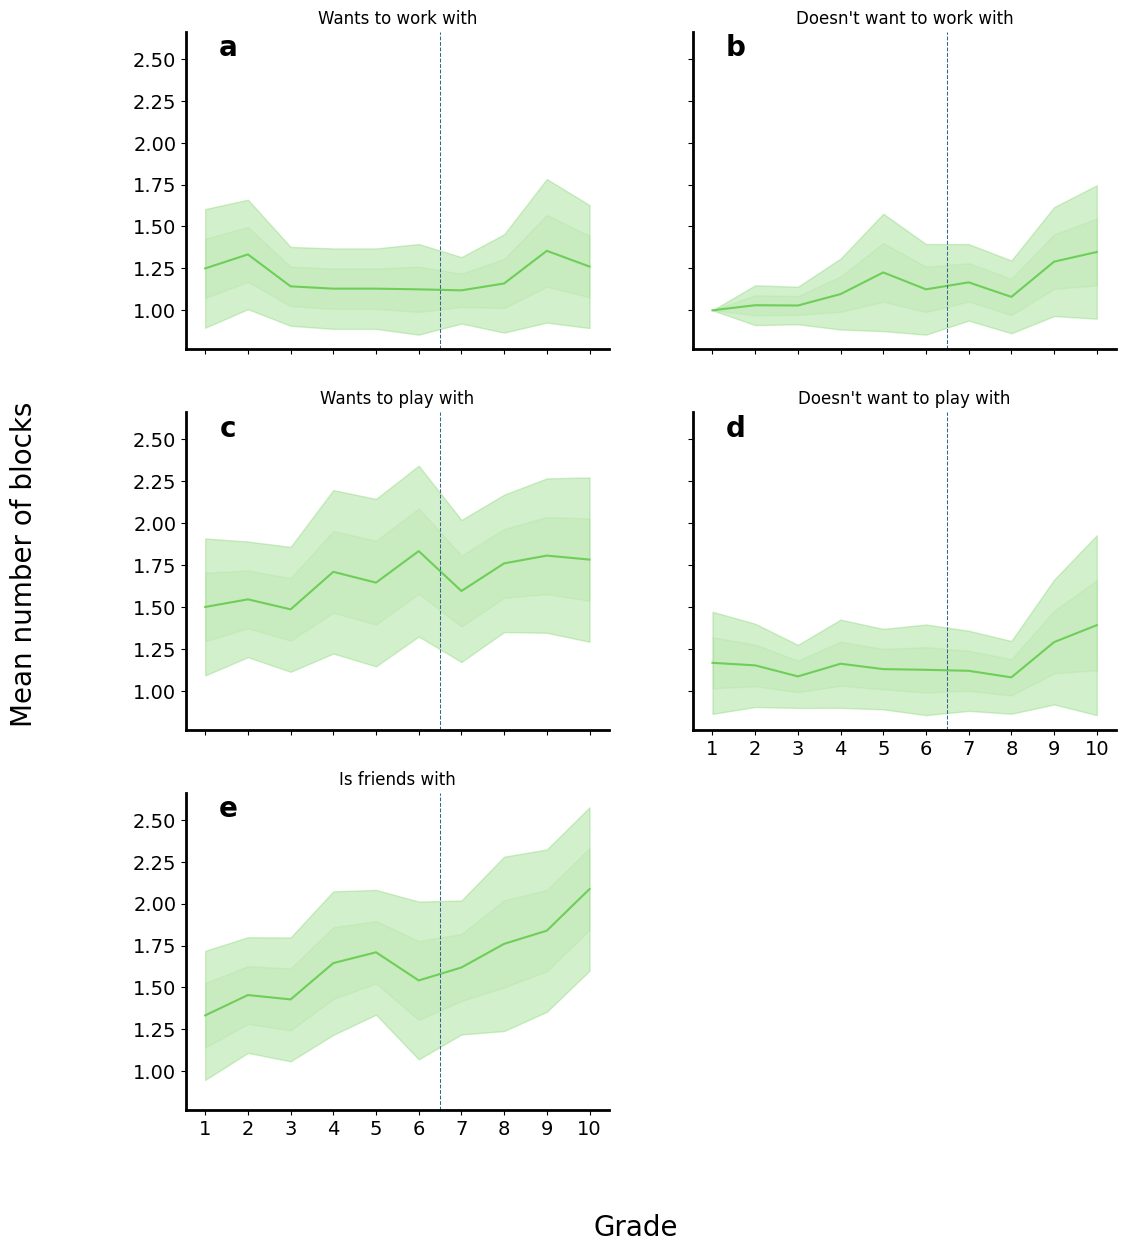

In [ ]:
questions = ["work_yes", "work_no", "play_yes", "play_no", "friend"]
# Letters to identify each subplot
subplot_letters = ['a', 'b', 'c', 'd', 'e', 'f']

# Create a main figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Iterate over the questions and plot
for i, question in enumerate(questions):
    df = tt.loc[tt.question == question, ["course", "classroom", "student", "value"]].drop_duplicates()
    points = compute_all_blocks(df)
    me = get_best_models(points)
    correlation_plot(me, question, axes[i], i)

# Remove the last (unused) subplot if the number of plots is odd
if len(axes) > len(questions):
    fig.delaxes(axes[-1])

fig.text(0.5, 0.02, 'Grade', ha='center', fontsize=title_size)
# Add a common y-axis label
fig.text(-0.01, 0.5, 'Mean number of blocks', ha='center', va='center', rotation='vertical', size = title_size)

In [ ]:
# Adjust layout for better fit and save the entire figure
plt.tight_layout()
fig.savefig("/mnt/plots/block_num.png", dpi=300)

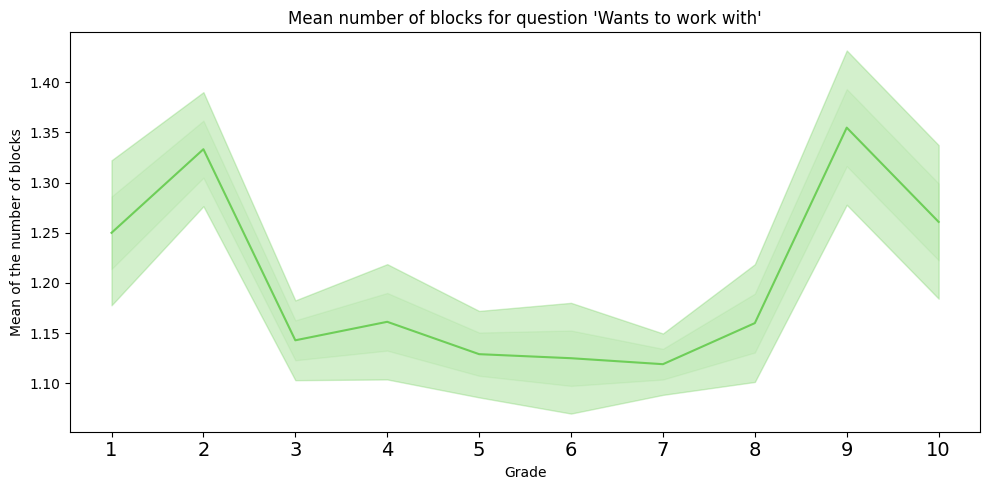

In [ ]:
compute_correlation_and_plot(tt, "work_yes")

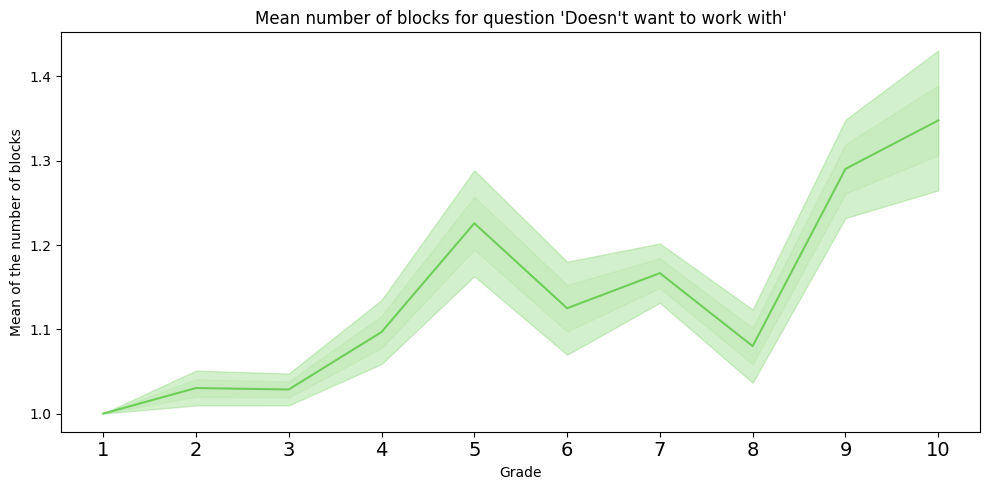

In [ ]:
compute_correlation_and_plot(tt, "work_no")

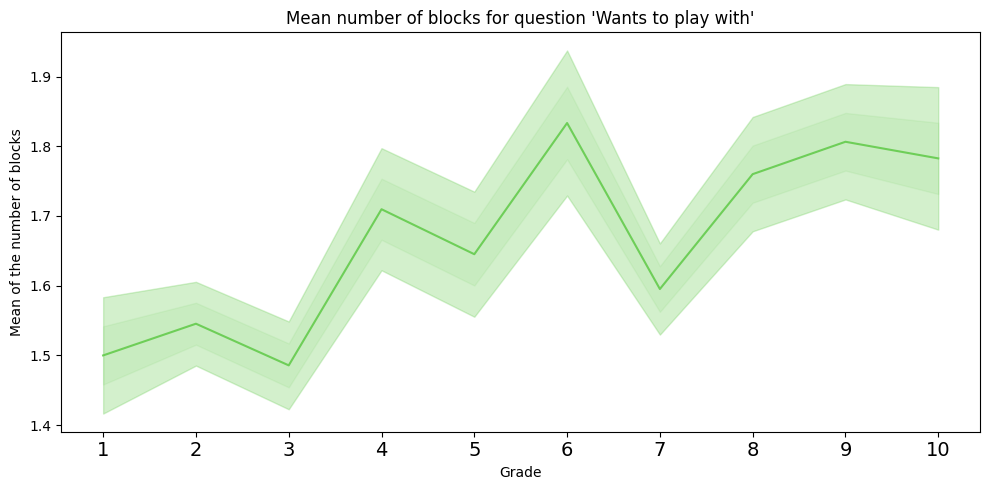

In [ ]:
compute_correlation_and_plot(tt, "play_yes")

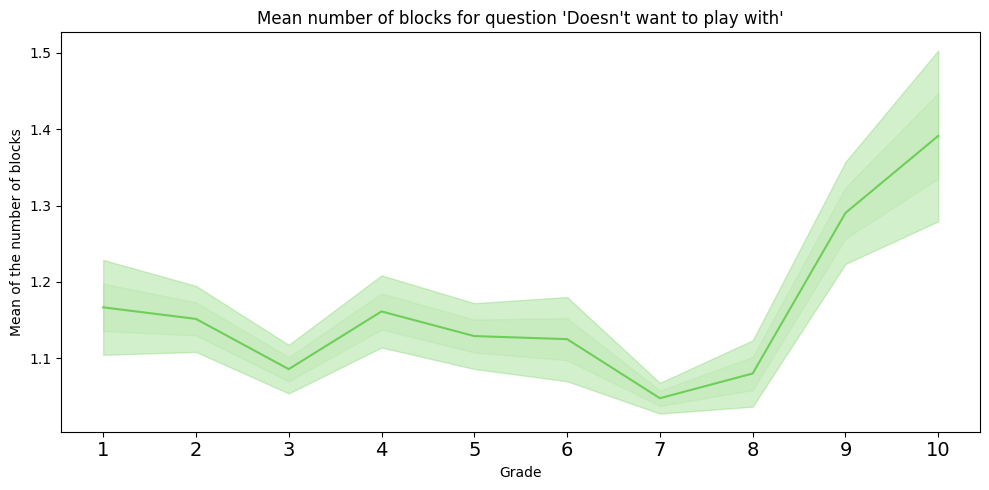

In [ ]:
compute_correlation_and_plot(tt, "play_no")

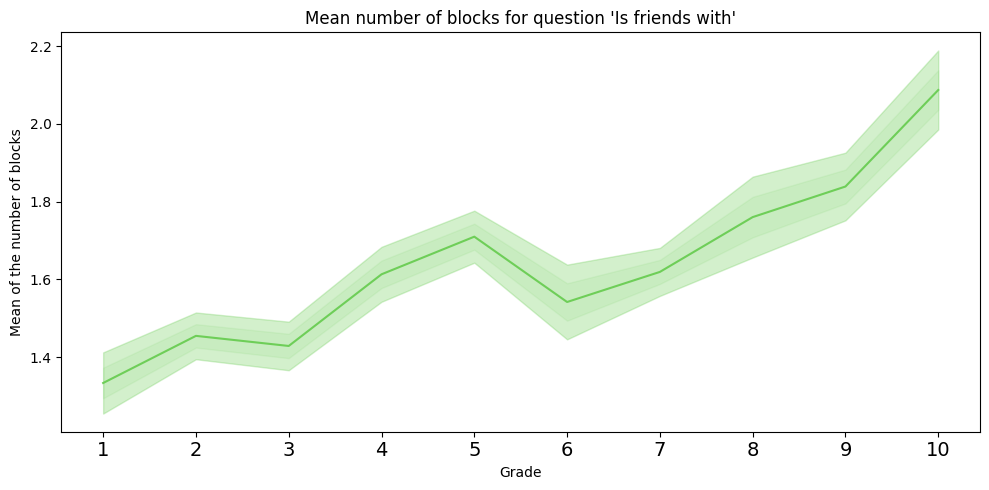

In [ ]:
compute_correlation_and_plot(tt, "friend")